In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pyvis.network import Network
from pyvis.options import Layout
from collections import defaultdict

In [2]:
def phi(f, alpha):
    return 1 - (1-f)**alpha

In [3]:
@dataclass
class Block:
    id: int
    slot: int
    height: int
    parent: int
    leader: int

In [4]:
@dataclass
class NetworkParams:
    mixnet_delay_mean: int # seconds
    mixnet_delay_var: int
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds
    no_network_delay: bool = False

    def sample_mixnet_delay(self):
        scale = self.mixnet_delay_var / self.mixnet_delay_mean
        shape = self.mixnet_delay_mean / scale
        return np.random.gamma(shape=shape, scale=scale)
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_slot(self, block_slot):
        if self.no_network_delay:
            return block_slot
        return self.pol_proof_time + self.sample_mixnet_delay() + self.sample_broadcast_delay(block_slot) + block_slot

In [5]:
@dataclass
class Params:
    SLOTS: int
    f: float
    honest_stake: np.array
    adversary_control: float

    @property
    def N(self):
        return len(self.honest_stake) + 1

    @property
    def stake(self):
        return np.append(self.honest_stake, self.honest_stake.sum() / (1/self.adversary_control - 1))
    
    @property
    def relative_stake(self):
        return self.stake / self.stake.sum()

    def slot_prob(self):
        return phi(self.f, self.relative_stake)

In [203]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network
        self.leaders = np.zeros((params.N, params.SLOTS), dtype=np.int64)
        self.blocks = []
        self.block_slots = np.array([], dtype=np.int64)
        self.block_heights = np.array([], dtype=np.int64)
        self.block_arrivals = np.zeros(shape=(params.N, 0), dtype=np.int64) # arrival time to each leader for each block

        # emit the genesis block
        self.emit_block(
            leader=0,
            slot=0,
            height=1,
            parent=-1,
        )
        self.block_arrivals[:,:] = 0 # all nodes see the genesis block

    def emit_block(self, leader, slot, height, parent):
        assert type(leader) in [int, np.int64]
        assert type(slot) in [int, np.int64]
        assert type(height) in [int, np.int64]
        assert type(parent) in [int, np.int64]

        block = Block(
            id=len(self.blocks),
            slot=slot,
            height=height,
            parent=parent,
            leader=leader,
        )
        self.blocks.append(block)
        self.block_slots = np.append(self.block_slots, block.slot)
        self.block_heights = np.append(self.block_heights, block.height)
    
        # decide when this block will arrive at each node
        new_block_arrival_by_node = self.network.block_arrival_slot(np.repeat(block.slot, self.params.N))

        if parent != -1:
            # the new block cannot arrive before it's parent
            parent_arrival_by_node = self.block_arrivals[:,parent]
            new_block_arrival_by_node = np.maximum(new_block_arrival_by_node, parent_arrival_by_node)
        
        self.block_arrivals = np.append(self.block_arrivals, new_block_arrival_by_node.reshape((self.params.N, 1)), axis=1)
        return block.id

    def emit_leader_block(self, leader, slot):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)

        parent = self.fork_choice(leader, slot)

        return self.emit_block(
            leader,
            slot,
            height=self.blocks[parent].height + 1,
            parent=parent,
        )

    def fork_choice(self, node, slot):
        return self.honest_chain(node, slot)[-1]

    def honest_chain(self, node, slot):
        seen_blocks = self.block_arrivals[node,:] <= slot
        block_ids = np.nonzero(seen_blocks)[0]

        children = defaultdict(list)
        for block in block_ids:
            children[self.blocks[block].parent].append(block)

        block_weight = self.block_weight(node, slot)

        chain = [self.blocks[0].id]

        while len(children[chain[-1]]) > 0:
            next_block = max(children[chain[-1]], key=lambda c: block_weight[c])
            chain.append(next_block)

        return chain

    def block_weight(self, node, slot, dbg=False):
        seen_blocks = self.block_arrivals[node,:] <= slot
        block_ids = np.nonzero(seen_blocks)[0]
        
        block_weight = {}

        children = defaultdict(list)
        if dbg:
            print("seen", seen_blocks)
            print("block_ids", block_ids)
            
        for b in sorted(block_ids, reverse=True):
            if dbg:
                print(f"block={b} weights={block_weight} children={children}")
            weight = 1
            for child in children[b]:
                weight += block_weight[child]

            block_weight[b] = weight
            children[self.blocks[b].parent].append(b)
            assert self.blocks[b].parent not in block_weight
            # curr = b
            # while self.blocks[curr].parent >= 0:
            #     block_weight[self.blocks[curr].parent] += 1
            #     curr = self.blocks[curr].parent

        return block_weight
        

    def plot_spacetime_diagram(self, MAX_SLOT=1000):
        alpha_index = sorted(range(self.params.N), key=lambda n: self.params.relative_stake[n])
        nodes = [f"$N_{n}$($\\alpha$={self.params.relative_stake[n]:.2f})" for n in alpha_index]
        messages = [(nodes[alpha_index.index(self.blocks[b].leader)], nodes[alpha_index.index(node)], self.blocks[b].slot, arrival_slot, f"$B_{{{b}}}$", b) for b, arrival_slots in enumerate(self.block_arrivals.T) for node, arrival_slot in enumerate(arrival_slots) if arrival_slot < MAX_SLOT]
    
        fig, ax = plt.subplots(figsize=(8,4))
        
        # Plot vertical lines for each node
        max_slot = max(s for _,_,start_t, end_t,_,_ in messages for s in [start_t, end_t])
        for i, node in enumerate(nodes):
            ax.plot([i, i], [0, max_slot], 'k-', linewidth=0.1)
            ax.text(i, max_slot + 30 * (0 if i % 2 == 0 else 1), node, ha='center', va='bottom')
        
        # Plot messages
        colors = plt.cm.rainbow(np.linspace(0, 1, len(messages)))
        for (start, end, start_time, end_time, label, b), color in zip(messages, colors):
            start_idx = nodes.index(start)
            end_idx = nodes.index(end)
            ax.annotate('', xy=(end_idx, end_time), xytext=(start_idx, start_time),
                        arrowprops=dict(arrowstyle='->', color="grey", lw=0.1))
            placement = 0
            mid_x = start_idx * (1 - placement) + end_idx * placement
            mid_y = start_time * (1 - placement) + end_time * placement
            ax.text(mid_x, mid_y, label, ha='center', va='center', 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

            # # draw parent pointers

            # block = self.blocks[b]
            # parent = self.blocks[block.parent]
            # parent_t = parent.slot
            # parent_idx = alpha_index.index(parent.leader)
        
            # ax.annotate('', xy=(parent_idx, parent_t), xytext=(end_idx, end_time),
            #             arrowprops=dict(arrowstyle='->', color="black", lw=2))

        for block in self.blocks:
            if block.parent == -1:
                continue

            parent = self.blocks[block.parent]
            parent_t = parent.slot
            parent_idx = alpha_index.index(parent.leader)

            child_t = block.slot
            child_idx = alpha_index.index(block.leader)
        
            ax.annotate('', xy=(parent_idx, parent_t), xytext=(child_idx, child_t),
                        arrowprops=dict(arrowstyle='-', color="black", lw=2))
            
        
        ax.set_xlim(-1, len(nodes))
        ax.set_ylim(0, max_slot + 70)
        ax.set_xticks(range(len(nodes)))
        ax.set_xticklabels([])
        # ax.set_yticks([])
        ax.set_title('Space-Time Diagram')
        ax.set_ylabel('Slot')
        
        plt.tight_layout()
        plt.show()

    def visualize_chain(self):
        honest_chain = self.honest_chain(0, self.block_arrivals.max())
        print("Honest chain length", len(honest_chain))
        honest_chain_set = set(honest_chain)
        
        layout = Layout()
        layout.hierachical = True
        
        G = Network(width=1600, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line')

        for block in self.blocks:
            # level = slot
            level = block.height
            color = "lightgrey"
            if block.id in honest_chain_set:
                color = "orange"

            G.add_node(int(block.id), level=level, color=color, label=f"{block.id}:s={block.slot},h={block.height}")
            if block.parent >= 0:
                G.add_edge(int(block.id), int(block.parent), width=1, color=color)

        
        return G.show("chain.html")

    def run(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        for s in range(1, self.params.SLOTS):
            if s > 0 and s % 100000 == 0:
                print(f"SIM={s}/{self.params.SLOTS}, blocks={len(self.blocks)}")
    
            # the adversary will not participate in the simulation
            # (implemented by never delivering blocks to the adversary)
            self.block_arrivals[-1,:] = self.params.SLOTS

            self.leaders[:,s] = np.random.random(size=self.params.N) < self.params.slot_prob()
            for leader in np.nonzero(self.leaders[:,s])[0]:
                if self.params.adversary_control is not None and leader == self.params.N - 1:
                    continue
                self.emit_leader_block(
                    leader,
                    s,
                )
    
    def adverserial_analysis(self, should_plot=True, seed=0):
        np.random.seed(seed)

        adversary = self.params.N-1 # adversary is always the last node in our simulations

        self.block_arrivals[adversary,:] = self.block_slots # we will say the adversary receives the blocks immidiately

        honest_chain = self.honest_chain(adversary, slot=self.params.SLOTS)
        honest_weight_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)
        honest_height_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)
        for b in honest_chain:
            temp_weight = np.zeros(self.params.SLOTS, dtype=np.int64) + self.block_weight(adversary, self.blocks[b].slot)[0]
            temp_weight[:self.blocks[b].slot] = 0
            honest_weight_by_slot = np.maximum(temp_weight, honest_weight_by_slot)

            temp_height = np.zeros(self.params.SLOTS, dtype=np.int64) + self.blocks[b].height
            temp_height[:self.blocks[b].slot] = 0
            honest_height_by_slot = np.maximum(temp_height, honest_height_by_slot)

        reorg_hist = np.zeros(self.params.SLOTS, dtype=np.int64)
        reorg_depths = np.array([], dtype=np.int64)

        if should_plot:
            plt.figure(figsize=(20, 6))
            ax = plt.subplot(121)
        
        adversary_active_slots = np.random.random(size=self.params.SLOTS) < phi(self.params.f, self.params.relative_stake[adversary])
        all_active_slots = (self.leaders.sum(axis=0) + adversary_active_slots) > 0
        
        for block in self.blocks:
            if block.id > 0 and block.id % 1000 == 0:
                print("Processing block", block)

            # honest_chain = self.honest_chain(adversary, slot=block.slot)

            nearest_honest_block = block
            while nearest_honest_block.height > len(honest_chain) or honest_chain[nearest_honest_block.height-1] != nearest_honest_block.id:
                assert nearest_honest_block.parent != -1
                nearest_honest_block = self.blocks[nearest_honest_block.parent]

            adv_init_fork_weight = self.block_weight(adversary, block.slot)[0]

            cumulative_rel_height = adversary_active_slots[block.slot+1:].cumsum()
            adverserial_weight_by_slot = adv_init_fork_weight + cumulative_rel_height
        
            adverserial_wins = adverserial_weight_by_slot > honest_weight_by_slot[block.slot + 1:]
            
            reorg_events = adverserial_wins & all_active_slots[block.slot+1:]
            
            reorg_depths = np.append(reorg_depths, honest_height_by_slot[block.slot+1:][reorg_events] - nearest_honest_block.height)
            reorg_hist += np.append(np.zeros(block.slot, dtype=np.int64), adverserial_wins).sum(axis=0)

            if should_plot:
                if reorg_events.sum() > 0:
                    first_slot = block.slot+1
                    last_slot = first_slot + np.nonzero(reorg_events)[0].max() + 1

                    ax.plot(np.arange(first_slot, last_slot), adverserial_weight_by_slot[:last_slot-first_slot]-honest_weight_by_slot[first_slot:last_slot], lw="1")
                    for event in np.nonzero(reorg_events)[0]:
                        plt.axvline(x = event + block.slot + 1, ymin = 0, ymax = 1, color ='red', lw=0.01)

        if should_plot:
            ax.plot(np.zeros(self.params.SLOTS), color="k", label=f"honest chain")
            _ = ax.set_title(f"max chain weight with adversery controlling {self.params.relative_stake[adversary] * 100:.0f}% of stake")
            _ = ax.set_ylabel("weight advantage")
            _ = ax.set_xlabel("slot")
            _ = ax.legend()

            ax = plt.subplot(122)
            _ = ax.grid(True)
            bins = (reorg_depths.max() if reorg_depths.sum() > 0 else 0) + 1
            _ = ax.hist(reorg_depths, density=False, bins=100)
            _ = ax.set_title(f"re-org depth with {self.params.relative_stake[adversary] * 100:.0f}% adversary")
            _ = ax.set_xlabel("re-org depth")
            _ = ax.set_ylabel("frequency")

        return reorg_depths

In [231]:
%%time
np.random.seed(0)
sim = Sim(
    params=Params(
        SLOTS=100000,
        f=0.05,
        adversary_control = 0.1,
        honest_stake = np.random.pareto(10, 1000)
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=10, # seconds
        no_network_delay=False
    )
)
sim.run(seed=5)

n_blocks_per_slot = len(sim.blocks) / sim.params.SLOTS
print("avg blocks per slot", n_blocks_per_slot)
print("Number of blocks", len(sim.blocks))
print("longest chain", max(b.height for b in sim.blocks))

avg blocks per slot 0.04709
Number of blocks 4709
longest chain 2346
CPU times: user 16.5 s, sys: 7.51 s, total: 24 s
Wall time: 24.7 s


In [232]:
# sim.visualize_chain()

Processing block Block(id=1000, slot=21253, height=495, parent=998, leader=935)
Processing block Block(id=2000, slot=42906, height=991, parent=1999, leader=589)
Processing block Block(id=3000, slot=64559, height=1499, parent=2998, leader=781)
Processing block Block(id=4000, slot=85787, height=1996, parent=3998, leader=421)


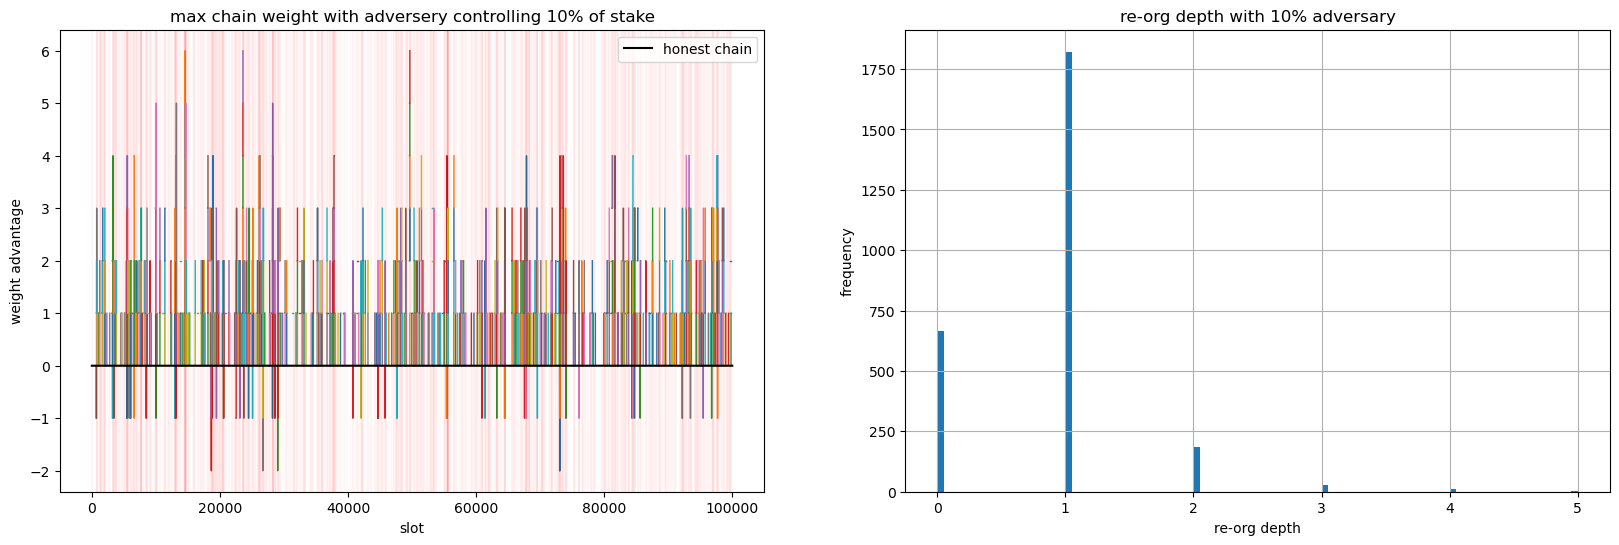

In [233]:
reorgs = sim.adverserial_analysis()

In [234]:
for DEPTH in range(20):
    print(f"{len(reorgs[reorgs >= DEPTH]) / sim.params.SLOTS*100:.2f}% of slots were reorged with depth >= {DEPTH}")

2.71% of slots were reorged with depth >= 0
2.04% of slots were reorged with depth >= 1
0.22% of slots were reorged with depth >= 2
0.04% of slots were reorged with depth >= 3
0.01% of slots were reorged with depth >= 4
0.00% of slots were reorged with depth >= 5
0.00% of slots were reorged with depth >= 6
0.00% of slots were reorged with depth >= 7
0.00% of slots were reorged with depth >= 8
0.00% of slots were reorged with depth >= 9
0.00% of slots were reorged with depth >= 10
0.00% of slots were reorged with depth >= 11
0.00% of slots were reorged with depth >= 12
0.00% of slots were reorged with depth >= 13
0.00% of slots were reorged with depth >= 14
0.00% of slots were reorged with depth >= 15
0.00% of slots were reorged with depth >= 16
0.00% of slots were reorged with depth >= 17
0.00% of slots were reorged with depth >= 18
0.00% of slots were reorged with depth >= 19


In [235]:
np.random.seed(0)
stake = np.random.pareto(10, 100)

sims = [Sim(
    params=Params(
        SLOTS=10000,
        f=0.05,
        adversary_control = i,
        honest_stake = stake
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=10, # seconds
        no_network_delay=False
    )
) for i in np.linspace(1e-3, 0.3, 10)]

for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/10
simulating 2/10
simulating 3/10
simulating 4/10
simulating 5/10
simulating 6/10
simulating 7/10
simulating 8/10
simulating 9/10
simulating 10/10
finished simulation, starting analysis


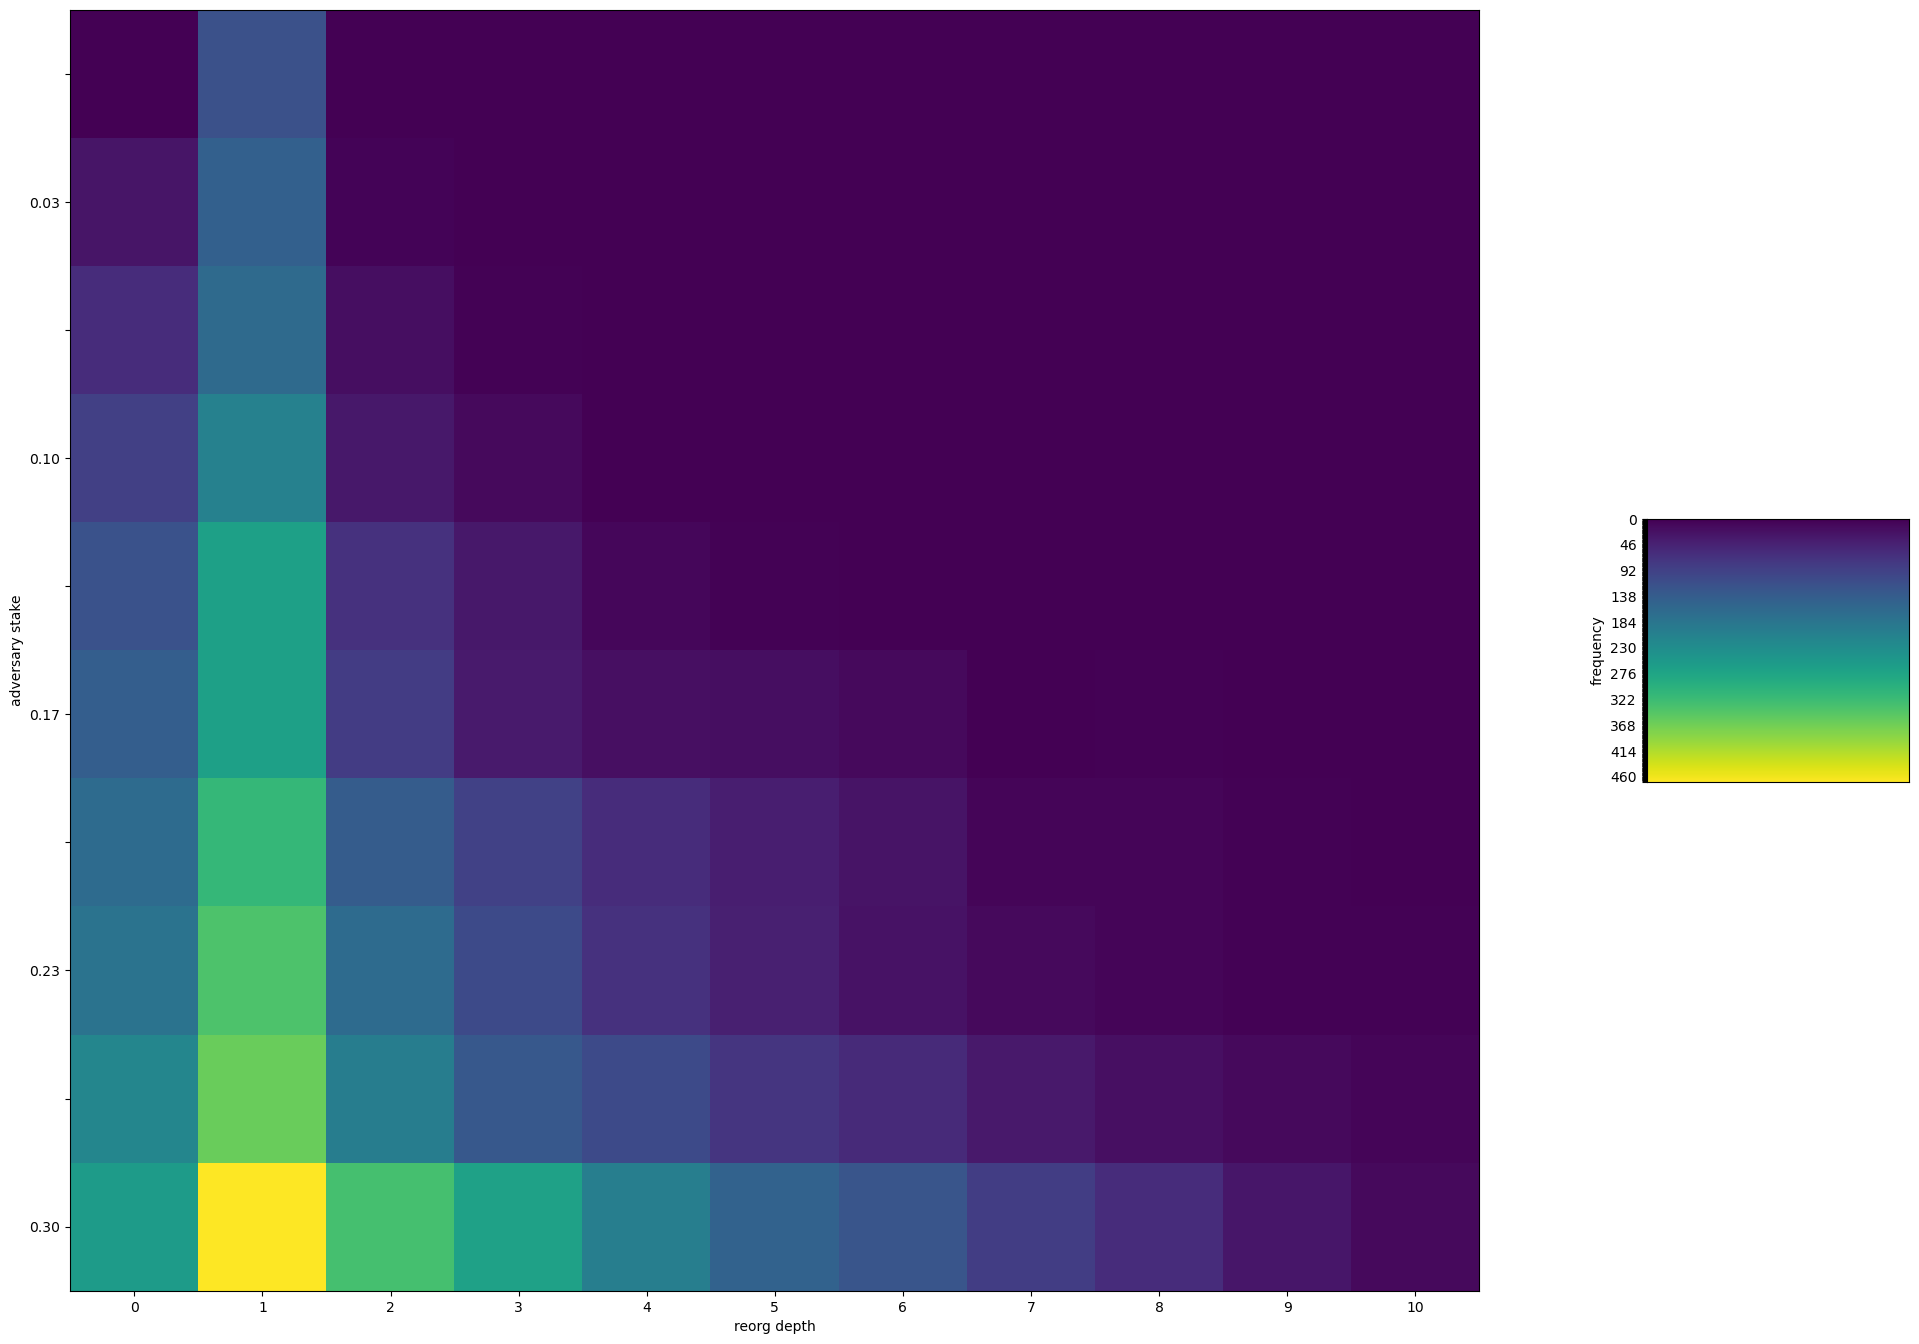

In [236]:
max_reorg_depth = max(a.max() if len(a) > 0 else 0 for a in advs)


heatmap = np.zeros((len(advs), max_reorg_depth), dtype=np.int64)

for i,  adv in enumerate(advs):
    for depth in range(max_reorg_depth):
        heatmap[i][depth] = (adv == depth).sum()

plt.figure(figsize=(40,40))
ax = plt.subplot(121)
im = ax.imshow(heatmap)

_ = ax.set_yticks(np.arange(len(sims)), labels=[f"{s.params.adversary_control:.2f}" if i % 2 == (len(sims) - 1) % 2 else None for i, s in enumerate(sims)])
_ = ax.set_xticks(np.arange(max_reorg_depth), labels=[r if r % (max_reorg_depth // 10) == 0 else None for r in range(max_reorg_depth)])
_ = ax.set_xlabel("reorg depth")
_ = ax.set_ylabel("adversary stake")

ax = plt.subplot(1,10,6)
scale = heatmap.max()
ax.imshow(np.arange(scale+1).reshape((1, scale+1)).T, extent=(1,0,1,0))
_ = ax.set_yticks(np.arange(scale+1) / scale, labels = [r if r % (scale // 10) == 0 else None for r in range(scale+1)])
_ = ax.set_xticks([], minor=False)
_ = ax.set_ylabel("frequency")

In [357]:
np.random.seed(0)
stake = np.random.pareto(10, 100)

sims = [Sim(
    params=Params(
        SLOTS=200000,
        f=0.05,
        adversary_control = 0.1,
        honest_stake = stake
    ),
    network=NetworkParams(
        mixnet_delay_mean=i, # seconds
        mixnet_delay_var=(i / 5)**2,
        broadcast_delay_mean=1e-6, # second
        pol_proof_time=0, # seconds
        no_network_delay=False
    )
) for i in np.linspace(1, 30, 5)]


for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/5
SIM=100000/200000, blocks=4637
simulating 2/5
SIM=100000/200000, blocks=4637
simulating 3/5
SIM=100000/200000, blocks=4637
simulating 4/5
SIM=100000/200000, blocks=4637
simulating 5/5
SIM=100000/200000, blocks=4637
finished simulation, starting analysis
Processing block Block(id=1000, slot=21112, height=947, parent=999, leader=70)
Processing block Block(id=2000, slot=43487, height=1905, parent=1999, leader=27)
Processing block Block(id=3000, slot=64768, height=2860, parent=2998, leader=74)
Processing block Block(id=4000, slot=86152, height=3827, parent=3999, leader=4)
Processing block Block(id=5000, slot=107463, height=4788, parent=4999, leader=53)
Processing block Block(id=6000, slot=129674, height=5754, parent=5999, leader=8)
Processing block Block(id=7000, slot=150939, height=6696, parent=6999, leader=57)
Processing block Block(id=8000, slot=172707, height=7644, parent=7999, leader=27)
Processing block Block(id=9000, slot=194724, height=8608, parent=8999, leader=66)
P

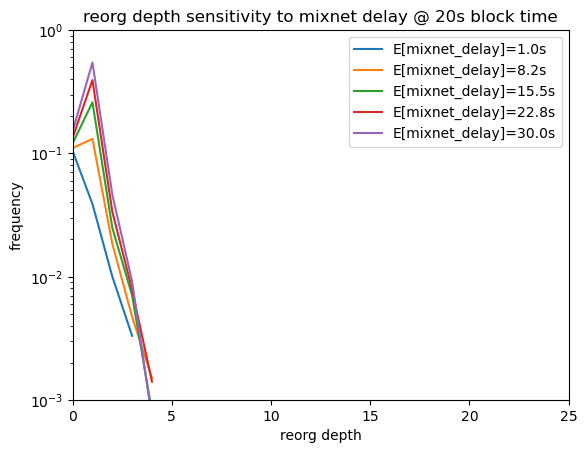

In [358]:
for s in range(len(sims)):
    max_depth = advs[s].max()
    count_by_depth = np.zeros(max_depth)
    for d in range(max_depth):
        count_by_depth[d] = (advs[s] == d).sum() / (sims[s].params.SLOTS * sims[s].params.f)
    plt.plot(np.arange(max_depth), count_by_depth, label=f"E[mixnet_delay]={sims[s].network.mixnet_delay_mean:.1f}s")

_ = plt.title(f"reorg depth sensitivity to mixnet delay @ {1/sims[s].params.f:.0f}s block time")
_ = plt.xlabel("reorg depth")
_ = plt.ylabel("frequency")
_ = plt.legend()
_ = plt.yscale("log")
_ = plt.xlim(0, 25)
_ = plt.ylim(10**-3,10**0)
# _ = plt.

In [244]:
np.random.seed(0)
stake = np.random.pareto(10, 100)

sims = [Sim(
    params=Params(
        SLOTS=int(1000 / i),
        f=i,
        adversary_control = 0.3,
        honest_stake = stake
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=2, # seconds
        no_network_delay=False
    )
) for i in np.linspace(1 / 600, 0.05, 5)]


for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/5
SIM=100000/600000, blocks=122
SIM=200000/600000, blocks=225
SIM=300000/600000, blocks=326
SIM=400000/600000, blocks=442
SIM=500000/600000, blocks=559
simulating 2/5
simulating 3/5
simulating 4/5
simulating 5/5
finished simulation, starting analysis


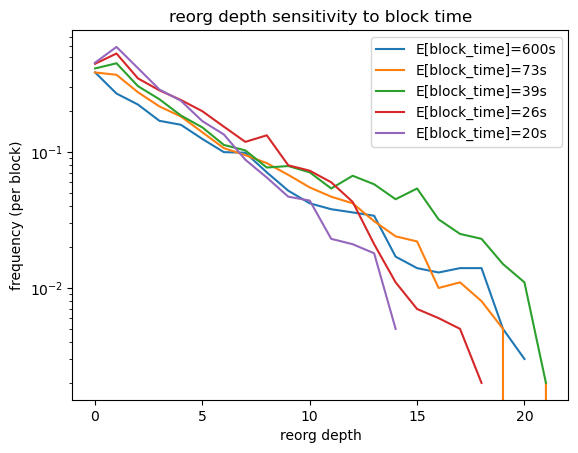

In [250]:
for s in range(len(sims)):
    max_depth = advs[s].max()
    count_by_depth = np.zeros(max_depth)
    for d in range(max_depth):
        count_by_depth[d] = (advs[s] == d).sum() / (sims[s].params.SLOTS * sims[s].params.f)
    plt.plot(np.arange(max_depth), count_by_depth, label=f"E[block_time]={1 / sims[s].params.f:.0f}s")

_ = plt.title("reorg depth sensitivity to block time")
_ = plt.xlabel("reorg depth")
_ = plt.ylabel("frequency (per block)")
_ = plt.legend()
_ = plt.yscale("log")

In [335]:
np.random.seed(0)
stake = np.random.pareto(10, 100)

mixnet_delay_mean = 10

sims = [Sim(
    params=Params(
        SLOTS=int(30000 * 1 / (1/mixnet_delay_mean / i)),
        f=1/mixnet_delay_mean / i,
        adversary_control = 0.3,
        honest_stake = stake
    ),
    network=NetworkParams(
        mixnet_delay_mean=mixnet_delay_mean, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=2, # seconds
        no_network_delay=False
    )
) for i in [1/2, 1, 2, 3]]


for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/4
SIM=100000/150000, blocks=15539
simulating 2/4
SIM=100000/300000, blocks=7454
SIM=200000/300000, blocks=14913
simulating 3/4
SIM=100000/600000, blocks=3648
SIM=200000/600000, blocks=7251
SIM=300000/600000, blocks=10815
SIM=400000/600000, blocks=14462
SIM=500000/600000, blocks=18038
simulating 4/4
SIM=100000/900000, blocks=2368
SIM=200000/900000, blocks=4745
SIM=300000/900000, blocks=7051
SIM=400000/900000, blocks=9482
SIM=500000/900000, blocks=11815
SIM=600000/900000, blocks=14139
SIM=700000/900000, blocks=16637
SIM=800000/900000, blocks=19004
finished simulation, starting analysis
Processing block Block(id=1000, slot=6647, height=331, parent=993, leader=23)
Processing block Block(id=2000, slot=12979, height=654, parent=1996, leader=72)
Processing block Block(id=3000, slot=19147, height=970, parent=2996, leader=70)
Processing block Block(id=4000, slot=25849, height=1301, parent=3994, leader=7)
Processing block Block(id=5000, slot=32235, height=1620, parent=4995, leader=5

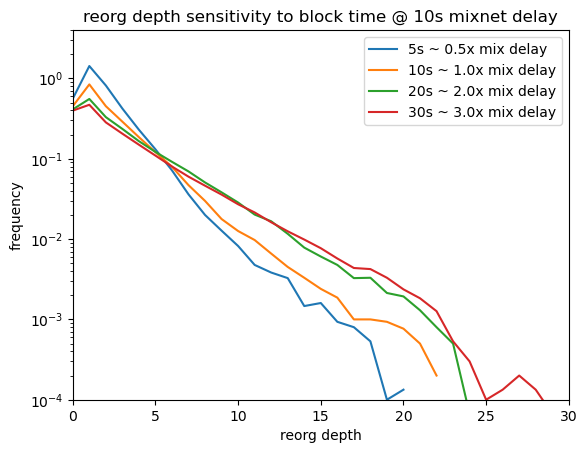

In [344]:
MAX=30

for s in range(len(sims)):
    
    max_depth = advs[s].max() if advs[s].sum() > 0 else 0
    max_depth = min(MAX, max_depth)
    count_by_depth = np.zeros(max_depth)
    for d in range(max_depth):
        count_by_depth[d] = (advs[s] == d).sum() 
    block_time = 1 / sims[s].params.f
    expected_blocks = sims[s].params.SLOTS / block_time
    plt.plot(np.arange(max_depth), count_by_depth / expected_blocks, label=f"{block_time:.0f}s ~ {block_time / sims[s].network.mixnet_delay_mean:.1f}x mix delay")

_ = plt.title(f"reorg depth sensitivity to block time @ {mixnet_delay_mean}s mixnet delay")
_ = plt.xlabel("reorg depth")
_ = plt.ylabel("frequency")
_ = plt.legend()
_ = plt.yscale("log")
_ = plt.xlim(0, MAX)
_ = plt.ylim(10**-4, 4)
# _ = plt.ylim(0,None)

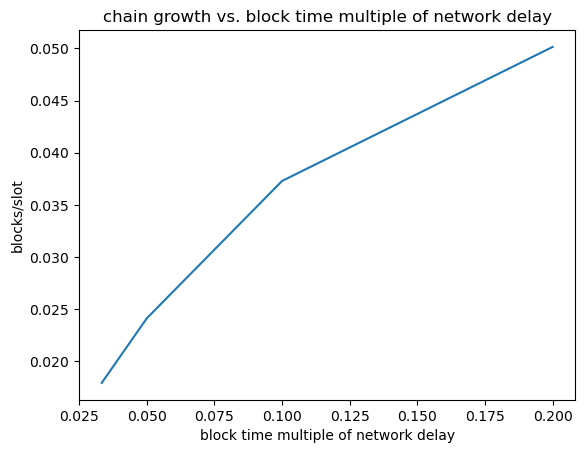

In [340]:
# _ = plt.plot([(1 / s.params.f) / s.network.mixnet_delay_mean for s in sims], [len(s.honest_chain()) / s.params.SLOTS for s in sims])
_ = plt.plot([s.params.f for s in sims], [len(s.honest_chain(-1, s.params.SLOTS)) / s.params.SLOTS for s in sims])

_ = plt.title("chain growth vs. block time multiple of network delay")
_ = plt.ylabel("blocks/slot")
_ = plt.xlabel("block time multiple of network delay")

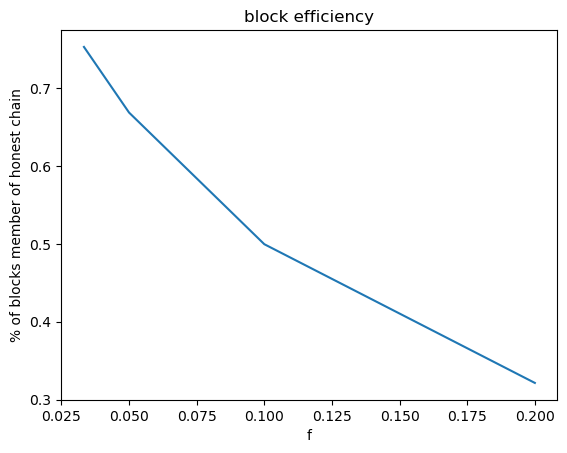

In [341]:
# _ = plt.plot([(1 / s.params.f) / s.network.mixnet_delay_mean for s in sims], [len(s.honest_chain()) / s.params.SLOTS for s in sims])
_ = plt.plot([s.params.f for s in sims], [len(s.honest_chain(-1, s.params.SLOTS)) / len(s.blocks) for s in sims])

_ = plt.title("block efficiency")
_ = plt.ylabel("% of blocks member of honest chain")
_ = plt.xlabel("f")